In [2]:
# import stats
import importlib
import stats as st
import pipeline as pp
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
# import cdist
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score


In [3]:
importlib.reload(st)
importlib.reload(pp)

data = pp.apply_pipeline_pd_tqdm(
    pd.read_csv('../datasets/sample/news_sample_cleaned_num_100k.csv', nrows=30000),
    [(pp.Binary_labels(), 'type'), ]
)

100%|██████████| 30000/30000 [00:00<00:00, 1335000.32it/s]


In [ ]:
truedata: pd.DataFrame = data[data["type"]==True][0:9000]
falsedata: pd.DataFrame = data[data["type"]==False][0:9000]

In [ ]:
wf = st.Word_frequency()
wf2 = st.Word_frequency()

truedata.apply(lambda x: wf.function_to_apply(x['content']), axis=1)
falsedata.apply(lambda x: wf.function_to_apply(x['content']), axis=1)

In [ ]:
wf.plot_fake_real(wf2.sorted_frequency)
wf2.plot_fake_real(wf.sorted_frequency)

wf.plot()


In [ ]:
wf.plotVenn(wf2.sorted_frequency)
wf.plot()
wf2.plot()

In [ ]:
print(wf2.totalRows)
print(wf.totalRows)

In [ ]:
# vectorizer = CountVectorizer(stop_words='english')
# tfidf = vectorizer.fit_transform(data['content'])

# print(X.shape)

## KMeans Clustering

The KMeans clustering algorithm uses the TF-IDF (Term Frequency-Inverse Document Frequency) matrix as input to cluster the documents into k clusters. The TF-IDF matrix represents each document as a vector of term frequencies, normalized by their inverse document frequency across the corpus.

The KMeans algorithm then iteratively assigns each document to a cluster and updates the cluster centroids until convergence. The assignment is based on the similarity between the document vector and the centroid of each cluster. The similarity metric used is the Euclidean distance between the document vector and the centroid vector in the TF-IDF space.

In addition to the TF-IDF matrix, the KMeans algorithm takes several parameters, including the number of clusters (k), the initialization method (e.g., k-means++), the maximum number of iterations, and the number of times the algorithm will be run with different random initializations.

In [4]:
# Vectorize the corpus using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data['content'].values.astype('U'))

### Plot the elbow curve to determine the optimal number of clusters.

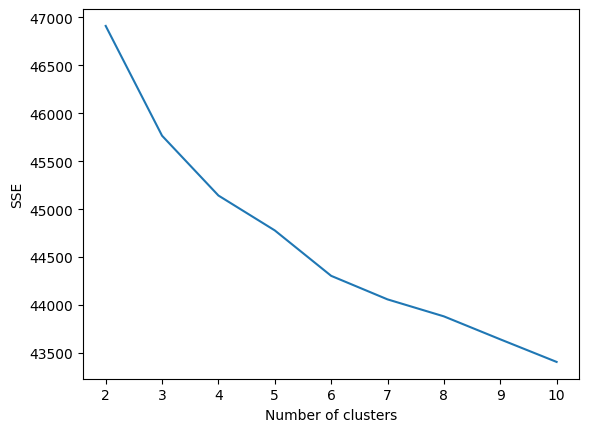

In [5]:
# Calculate SSE for different values of k
sse = {}
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init=10).fit(tfidf)
    sse[k] = kmeans.inertia_ 

# Plot SSE against k
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of clusters")
plt.ylabel("SSE")
plt.show()

### Perform clustering using the result from the elbow curve.

In [5]:
# Perform K-Means clustering


num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100, n_init=10)
kmeans.fit(tfidf)



# Print the top terms in each cluster
# print("Top terms per cluster:")
# order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
# terms = tfidf_vectorizer.get_feature_names_out()
# for i in range(num_clusters):
#     # print(f"Cluster {i} terms: ", end='')
#     for j in order_centroids[i, :10]:
#         print(f"{terms[j]}, ", end='')
#     # print()

# # Visualize the clusters
# plt.scatter(tfidf[:, 0], tfidf[:, 1], c=kmeans.labels_, cmap='rainbow')
# plt.show()

KMeans(max_iter=100, n_clusters=6, n_init=10)

In [6]:
# Calculate silhouette score
silhouette_avg = silhouette_score(tfidf.toarray(), kmeans.labels_, metric='euclidean', n_jobs=-1)

# Print silhouette score
print("The average silhouette_score is :", silhouette_avg)

KeyboardInterrupt: 

: 

### Plot the clusters using a a scatterplot in 2d with PCA.

/var/folders/85/ql5yb2_14pzc9s20ccfhqs7m0000gn/T/ipykernel_11321/3290963992.py:11: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(tfidf_2d[:, 0], tfidf_2d[:, 1], c=colors, cmap='rainbow')


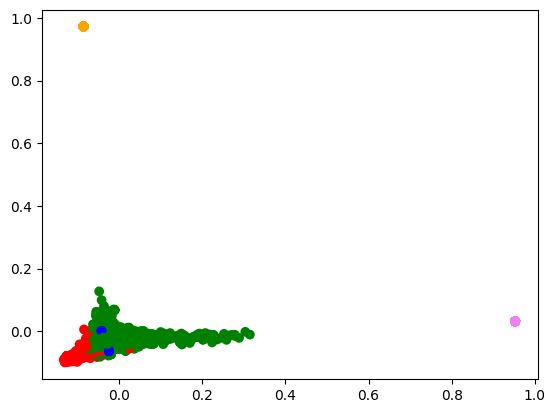

In [5]:
from sklearn.decomposition import PCA

# Reduce the dimensions of the data using PCA
pca = PCA(n_components=2)
tfidf_2d = pca.fit_transform(tfidf.toarray())

label_to_color = {0: 'red', 1: 'blue', 2: 'green', 3: 'violet', 4: "yellow", 5: "orange"}
colors = [label_to_color[label] for label in kmeans.labels_]

# Visualize the clusters
plt.scatter(tfidf_2d[:, 0], tfidf_2d[:, 1], 
            c=colors, 
            cmap='rainbow',
            )
plt.show()

In [7]:
kmeans.labels_

array([2, 2, 2, ..., 2, 2, 2], dtype=int32)

In [15]:
# Print the top terms in each cluster
print("Top terms per cluster:")
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1] # sort the centroids by their distance to the origin
terms = tfidf_vectorizer.get_feature_names_out()
for i in range(num_clusters):
    print(f"Cluster {label_to_color[i]} terms: ", end='')
    for j in order_centroids[i, :10]:
        print(f"{terms[j]}, ", end='')
    print()

Top terms per cluster:
Cluster red terms: num, said, mr, date, url, state, trump, peopl, new, presid, 
Cluster blue terms: iran, iranian, nuclear, suprem, islam, minist, leader, tehran, ali, republ, 
Cluster green terms: num, url, date, use, like, said, news, new, time, email, 
Cluster violet terms: num, rec, date, url, trump, properti, valu, talk, republican, moor, 
Cluster yellow terms: tor, tail, anonymis, usb, browser, dvd, submiss, stick, comput, internet, 
Cluster orange terms: updat, bookmark, sputnik, dear, excit, radio, voic, websit, russia, latest, 


In [16]:
# Print the number of documents in each cluster
for i in range(num_clusters):
    print(f"Number of documents in cluster {i}, {label_to_color[i]}: {len(np.arange(0, tfidf.shape[0])[kmeans.labels_ == i])}")

Number of documents in cluster 0, red: 16245
Number of documents in cluster 1, blue: 1848
Number of documents in cluster 2, green: 27911
Number of documents in cluster 3, violet: 2132
Number of documents in cluster 4, yellow: 1169
Number of documents in cluster 5, orange: 695


In [7]:
# Print a sample of documents in each cluster
print("Sample documents in each cluster:")
for i in range(num_clusters):
    print(f"********************************************************************")
    print(f"Cluster {i} documents: ")
    cluster = np.arange(0, tfidf.shape[0])[kmeans.labels_ == i]
    sample_docs = np.random.choice(cluster, 5, replace=False)
    for doc_index in sample_docs:
        print(f"\nTitle: {data['title'].iloc[doc_index]}")
        print(f"Content: {data['content'].iloc[doc_index]}")
        print("-"*50)


Sample documents in each cluster:
********************************************************************
Cluster 0 documents: 

Title: Cable: 1976BONN07688
Content: ['raw', 'content', 'confidenti', 'page', '<num>', 'bonn', '<date>', '<date>', 'z', '<num>', 'action', 'eur', '<num>', 'info', '<date>', 'iso', '<num>', 'ciae', '<num>', 'dode', '<num>', 'pm', '<num>', 'h', '<num>', 'inr', '<num>', 'l', '<num>', 'nsae', '<num>', 'nsc', '<num>', 'pa', '<num>', 'pr', '<num>', 'sp', '<num>', 'ss', '<num>', 'usia', '<num>', 'eb', '<num>', 'scct', '<num>', 'sca', '<num>', 'io', '<num>', 'acda', '<num>', 'trse', '<num>', 'saj', '<num>', '<num>', 'w', '<date>', 'r', '<date>', 'z', 'may', '<num>', 'fm', 'amembassi', 'bonn', 'secstat', 'washdc', '<date>', 'info', 'usmiss', 'usberlin', 'amembassi', 'berlin', 'amembassi', 'pari', 'amembassi', 'london', 'amembassi', 'moscow', 'usmiss', 'nato', 'brussel', 'c', 'n', 'f', 'e', 'n', 'l', 'bonn', '<date>', '<url>', '<date>', 'gd', 'tag', 'pfor', 'pgov', 'wb', 

## Outliers

In [23]:
# Compute the distance between each point and its centroid
distances = np.sqrt(((tfidf.toarray() - kmeans.cluster_centers_[kmeans.labels_])**2).sum(axis=1))

Outliers: [ 1368  2717  4677  4110  2691  1359    72  2195 12080 17643]


In [50]:
data['distance'] = distances

for i in range(kmeans.n_clusters):
    cluster_df = data[data['cluster'] == i]
    outliers = cluster_df.nlargest(5, 'distance')
    print(f"Top 10 outliers in cluster {i}:")
    # if i ==2 :
    print(outliers['distance'])

Top 10 outliers in cluster 0:
87     1.169379e-15
89     1.169379e-15
91     1.169379e-15
97     1.169379e-15
127    1.169379e-15
Name: distance, dtype: float64
Top 10 outliers in cluster 1:
6     7.061752e-16
17    7.061752e-16
26    7.061752e-16
62    7.061752e-16
86    7.061752e-16
Name: distance, dtype: float64
Top 10 outliers in cluster 2:
1368    1.012147
2717    1.012116
4677    1.012096
4110    1.011555
2691    1.011547
Name: distance, dtype: float64
Top 10 outliers in cluster 3:
3023     1.003620
10748    0.858575
247      0.805435
262      0.805435
290      0.805435
Name: distance, dtype: float64


In [34]:
# Identify the outliers as points that are farthest away from their centroid
outliers = np.argsort(distances)[::-1][:30]  # top 10 outliers
print('Outliers:', outliers)

Outliers: [ 1368  2717  4677  4110  2691  1359    72  2195 12080 17643 15346 10104
  1073 16260 13464  9848 11796 14053 12996 15204   378  9065  8345  1245
  3765  1277 18375 19388 11231 10694]


In [35]:
for idx in outliers:
    print(f"\nOutlier {idx}:")
    print(f"Domain: {data['domain'][idx]}")
    print(f"Title: {data['title'][idx]}")
    print(f"Content: {data['content'][idx]}")


Outlier 1368:
Domain: pravda.ru
Title: Восточные красавицы дают жару
Content: ['necar', 'zadegan']

Outlier 2717:
Domain: dailykos.com
Title: Daily Kos :: Blogroll for abhinavagupta
Content: ['abhinavagupta', 'blogrol', 'blogrol', 'abhinavagupta', 'yet']

Outlier 4677:
Domain: pravda.ru
Title: Быки смерти покидают Испанию
Content: ['v', 'xvi', 'corrida', 'de', 'toro', 'toro', 'xv', 'xvi', 'xviii', 'v', '!', '?', '!']

Outlier 4110:
Domain: katehon.com
Title: Parlamento
Content: ['una', 'recent', 'proposta', 'di', 'legg', 'non', 'ancora', 'per', 'discussa', 'dal', 'parlamento', 'italiano', 'ha', 'sollevato', 'un', 'vero', 'e', 'proprio', 'vespaio', 'cui', 'ha', 'fatto', 'seguito', 'una', 'general', 'levata', 'di', 'scudi', 'da', 'part', 'di', 'chi', 'si', 'occupa', 'di', 'informazion', 'parallela', 'quella', 'informazion', 'ch']

Outlier 2691:
Domain: nutritionfacts.org
Title: NutritionFacts.org
Content: ['la', 'nueva', 'superestrella', 'antioxidant', 'clasificacin', 'de', 'lo', 'alime

In [9]:
# add the cluster labels as a new column to the dataframe
data['cluster'] = kmeans.labels_

# create a list of dataframes, one for each cluster
cluster_dfs = [data[data['cluster'] == i] for i in range(kmeans.n_clusters)]

In [10]:
# print the number of data points in each cluster dataframe
for i, cluster_df in enumerate(cluster_dfs):
    print(f"Number of data points in cluster {i}, {label_to_color[i]}: {len(cluster_df)}")
    # write to csv
    cluster_df.to_csv(f"cluster_{i}.csv", index=False)

Number of data points in cluster 0, red: 918
Number of data points in cluster 1, blue: 488
Number of data points in cluster 2, green: 17196
Number of data points in cluster 3, violet: 722
Number of data points in cluster 4, yellow: 184
Number of data points in cluster 5, orange: 492


## Stacked bar plot for each cluster

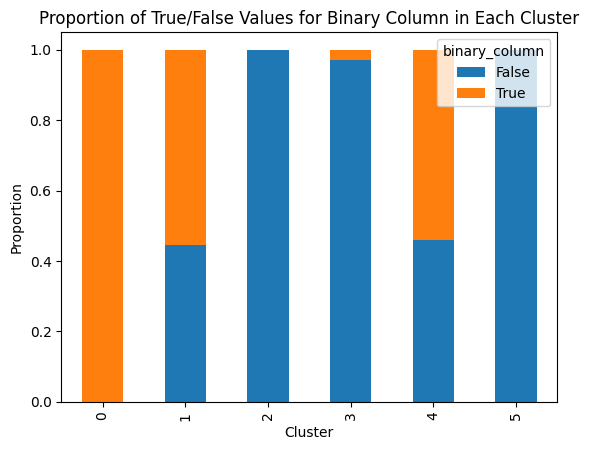

In [7]:
# Create contingency table of true/false values for binary column in each cluster
df = pd.DataFrame({'cluster': kmeans.labels_, 'binary_column': data['type']})
contingency_table = pd.crosstab(df['cluster'], df['binary_column'], normalize='index')

# Plot stacked bar chart
contingency_table.plot(kind='bar', stacked=True)
plt.title('Proportion of True/False Values for Binary Column in Each Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.show()

In [41]:


# assume `df` is the original dataframe containing the data points
# and `kmeans` is the fitted KMeans model

# add the cluster labels as a new column to the dataframe


# iterate over each cluster and identify the top outliers
for i in range(kmeans.n_clusters):
    cluster_df = data[data['cluster'] == i]
    distances = np.linalg.norm(cluster_df - kmeans.cluster_centers_[i], axis=1)
    outliers = cluster_df.iloc[np.argsort(distances)[::-1][:10]]
    print(f"Top 10 outliers in cluster {i}:")
    print(outliers)


ValueError: Unable to coerce to Series, length must be 17: given 118109

In [8]:
# Calculate distances from each data point to its nearest centroid
distances = np.min(cdist(tfidf.toarray(), kmeans.cluster_centers_, 'euclidean'), axis=1)

# Calculate the interquartile range and the upper and lower bounds for outlier detection
q1, q3 = np.percentile(distances, [25, 75])
iqr = q3 - q1
lower_bound = q1 - 10.5 * iqr
upper_bound = q3 + 10.5 * iqr

# Identify the outliers
outliers = np.where((distances < lower_bound) | (distances > upper_bound))[0]

# Print the number of outliers and their indices
print(f"Number of outliers: {len(outliers)}")
print("Outlier indices: ", outliers)

# Print the content of the outlier articles
for idx in outliers:
    print(f"\nOutlier {idx}:\n{data['content'][idx]}")
